# Path setup & import packages

In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
import sys
import os
root_path = '../../' # path to project root
sys.path.append('{}/code'.format(root_path))
sys.path.append('{}/code/core'.format(root_path))
sys.path.append('{}/code/datasets/'.format(root_path))
sys.path.insert(0,'{}/code/ptranking'.format(root_path))

from core.ranking_utils import *
from core.mallows import *
from core.ws_ranking import *
from core.ws_real_workflow import * 
from core.ws_regression import *
from core.labelling.feature_lf import *
from ptranking_wrapper import PtrankingWrapper
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import datasets_factory 
import numpy as np 
import yaml
import matplotlib.pyplot as plt
import pickle
import copy
import scipy.stats as ss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
seed = 42
features = ['yearpublished', 'minplayers', 'maxplayers', 'playingtime',
                    'minplaytime', 'maxplaytime', 'minage',
                    'owned', 'trading',
                    'wanting', 'wishing', 'numcomments',
                    'numweights', 'averageweight']
label_feature = 'average'

# Fully supervised

In [3]:
# read data
df = pd.read_csv(f'{root_path}/data/boardgames.csv'.format(data_dir), index_col=0)
X, Y = df[features], df[label_feature]

# split data
train_fraction = 0.75
indices_train, indices_test = train_test_split(list(range(len(Y))), train_size=train_fraction, random_state=seed)
X_train = X.iloc[indices_train]
Y_train = Y[indices_train]
X_test = X.iloc[indices_test]
Y_test = Y[indices_test]

# model declaration and fit
model = Pipeline([
    ("std", StandardScaler()),
    ("model", GradientBoostingRegressor(n_estimators=250, random_state=seed))
])
model.fit(X_train, Y_train)
Y_test_pred = model.predict(X_test)
true_mse = mean_squared_error(Y_test, Y_test_pred)
print('MSE', true_mse)

MSE 0.2836070654657973


# Weak Supervision

In [4]:
Y_mean = Y.mean() # centering for LF generation
Y_var = Y.var()

param_err, mu_err, score, mse = {}, {}, {}, {}

for m in range(3, 20):
    n = len(Y)
    L, true_Sigma = generate_lfs(m, n, Y - Y_mean, Y_var)

    lm = LabelModel()
    lm.fit(L, Y_var)
    lm.inference(L)
    Y_hat = lm.Y_hat + Y_mean

    
    Sigma_hat = lm.Sigma_hat
    param_err[m] = np.linalg.norm(Sigma_hat - true_Sigma) / (m+1)**2
    mu_err[m]    = np.linalg.norm(Sigma_hat[:m,m] - true_Sigma[:m,m]) / m
    score[m] = lm.score(Y - Y_mean)
    
    
    # # split data
    indices_train, indices_test = train_test_split(list(range(len(Y))), train_size=train_fraction, random_state=seed)
    X_train = X.iloc[indices_train]
    Y_train = Y_hat[indices_train]
    X_test = X.iloc[indices_test]
    Y_test = Y[indices_test]

    # model declaration and fit
    model = Pipeline([
        ("std", StandardScaler()),
        ("model", GradientBoostingRegressor(n_estimators=250, random_state=seed))
    ])
    model.fit(X_train, Y_train)
    Y_test_pred = model.predict(X_test)
    mse[m] = mean_squared_error(Y_test, Y_test_pred)
    print('numLFs', m, 'MSE', mse[m])

numLFs 3 MSE 0.3004996354533219
numLFs 4 MSE 0.28999899769760284
numLFs 5 MSE 0.2896369372141331
numLFs 6 MSE 0.28812075440539264
numLFs 7 MSE 0.28678490007851987
numLFs 8 MSE 0.2842620500837292
numLFs 9 MSE 0.2831771296591451
numLFs 10 MSE 0.2837689008113989
numLFs 11 MSE 0.28337831971764776
numLFs 12 MSE 0.28339921568433935
numLFs 13 MSE 0.28168719408449827
numLFs 14 MSE 0.2816711449808872
numLFs 15 MSE 0.28063098840361117
numLFs 16 MSE 0.2852406764317049
numLFs 17 MSE 0.2807375687374445
numLFs 18 MSE 0.2827638411969839
numLFs 19 MSE 0.2823257524899007


# Fully supervision with small true

In [5]:
true_small_mse = {}

for sample_percent in range(10, 60, 10):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_fraction, random_state=seed)
    sample_size = int(len(X_train) * sample_percent / 100)
    np.random.seed(seed=seed)
    sample_indices = np.random.choice(list(range(len(X_train))), size=sample_size, replace=False)
    X_train = X_train.iloc[sample_indices]
    Y_train = Y_train.iloc[sample_indices]

    # model declaration and fit
    model = Pipeline([
        ("std", StandardScaler()),
        ("model", GradientBoostingRegressor(n_estimators=250, random_state=seed))
    ])
    model.fit(X_train, Y_train)
    
    Y_test_pred = model.predict(X_test)
    true_small_mse[sample_percent] = mean_squared_error(Y_test, Y_test_pred)
    print('sample_percent', sample_percent, 'MSE', true_small_mse[sample_percent])

sample_percent 10 MSE 0.31856496494431785
sample_percent 20 MSE 0.30558870930268417
sample_percent 30 MSE 0.30587138562574484
sample_percent 40 MSE 0.287623588446389
sample_percent 50 MSE 0.28710663133992376


# Result data handling

In [6]:
param_err = pd.Series(param_err)
mu_err = pd.Series(mu_err)
score = pd.Series(score)
mse = pd.Series(mse)

# Result visualization

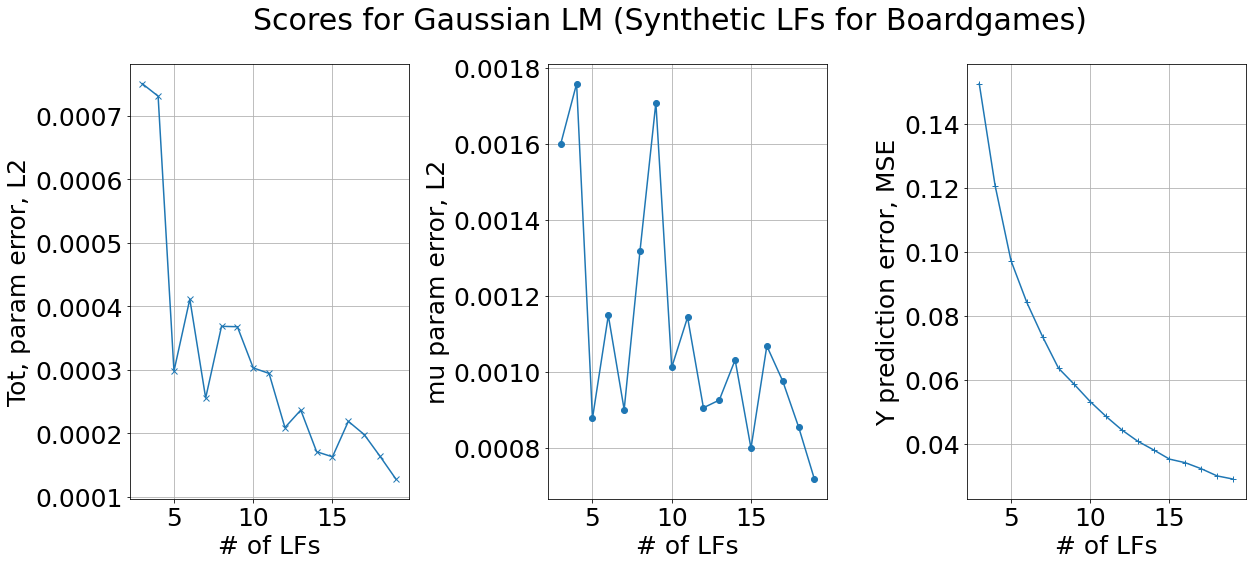

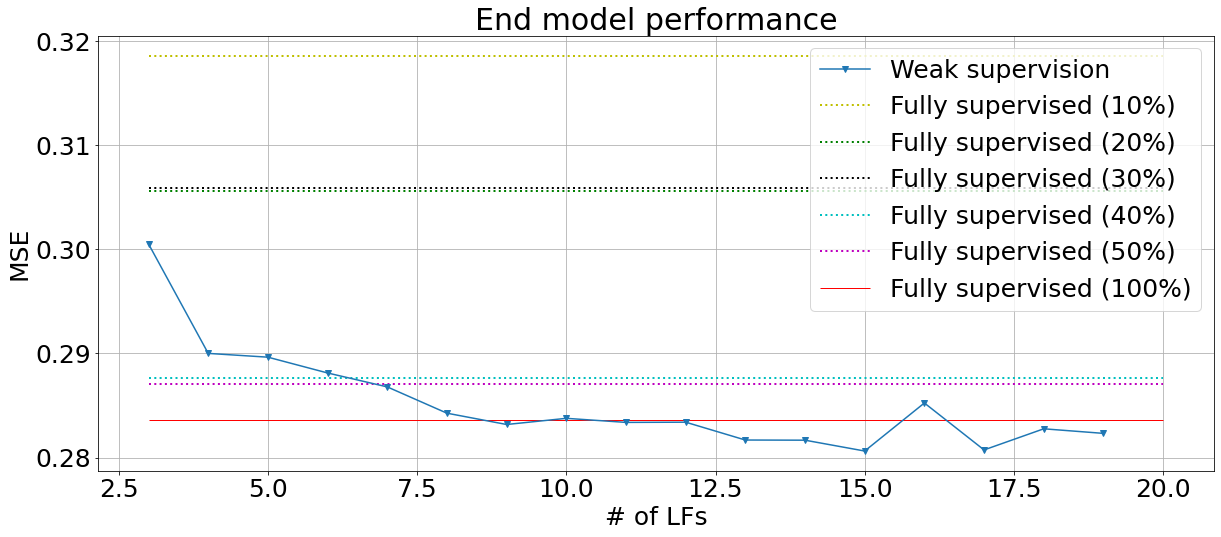

In [9]:
plt.rcParams['font.size'] = '25'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))

fig.suptitle('Scores for Gaussian LM (Synthetic LFs for Boardgames)')
ax1.plot(param_err, marker='x')
ax1.set(ylabel='Tot, param error, L2')
ax1.set(xlabel='# of LFs')
ax1.grid()
ax2.plot(mu_err, marker='o')
ax2.set(ylabel='mu param error, L2')
ax2.set(xlabel='# of LFs')
ax2.grid()
ax3.plot(score, marker='+')
ax3.set(ylabel='Y prediction error, MSE')
ax3.set(xlabel='# of LFs')
ax3.grid()
fig.subplots_adjust(wspace=.5)

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(mse, marker='v', label='Weak supervision')
colors = ['y', 'g', 'k', 'c', 'm']
for i, sample_percent in enumerate(true_small_mse):
    ax.hlines(y=true_small_mse[sample_percent], linewidth=2, xmin=3, xmax=20, color=colors[i],
            linestyles='dotted', label=f'Fully supervised ({sample_percent}%)')
    
ax.hlines(y=true_mse, linewidth=1, xmin=3, xmax=20, color='r', label='Fully supervised (100%)')
ax.grid()
ax.legend()
ax.set(xlabel='# of LFs', ylabel='MSE', title='End model performance')
plt.show()